In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
from matplotlib import pyplot as plt
import random
import time
import math
import networkx as nx
from scipy.spatial import distance
from SweepIntersectorLib.SweepIntersector import SweepIntersector

In [2]:
def equilateral_triangle(A, B):
    # Extract x and y coordinates from points A and B
    Ax,Ay = A[0],A[1]
    Bx,By = B[0],B[1]
    # Calculate the x and y components of vector AB
    AB_x = Bx - Ax
    AB_y = By - Ay
    # Calculate the length of vector AB
    AB_length = np.sqrt(np.square(AB_x) + np.square(AB_y))
    # Calculate the values of cos(60°) and sin(60°), which are used to rotate vector AB to get vector AC
    cos60 = np.cos(np.pi / 3)
    sin60 = np.sin(np.pi / 3)
     # Rotate vector AB by 60 degrees using a rotation matrix to obtain the x and y components of vector AC
    AC_x = cos60 * AB_x - sin60 * AB_y
    AC_y = sin60 * AB_x + cos60 * AB_y
     # Calculate the coordinates of point C, which is A plus vector AC
    Cx1 = Ax + AC_x
    Cy1 = Ay + AC_y
    return np.array([Cx1,Cy1])

In [3]:
def find_circle_center(point1, point2, point3):
    # Calculate the midpoint between two points
    midpoint12 = (point1 + point2) / 2
    midpoint23 = (point2 + point3) / 2

    # Calculate the slopes between the midpoints and the points
    slope12 = -(point2[0] - point1[0]) / ((point2[1] - point1[1]) + 1e-9)
    slope23 = -(point3[0] - point2[0]) / ((point3[1] - point2[1]) + 1e-9)

    # Calculate the x-coordinate of the circle center
    center_x = (slope12 * midpoint12[0] - slope23 * midpoint23[0] + midpoint23[1] - midpoint12[1]) / (slope12 - slope23 + 1e-9)

    #  Calculate the y-coordinate of the circle center
    center_y = slope12 * (center_x - midpoint12[0]) + midpoint12[1]

    # Get the coordinates of the circle center
    center = np.array([center_x, center_y])

    return center

In [4]:
def compute_start_end_angle(center, start, end):
    # Extract the x and y coordinates of the center, start, and end points
    center_x, center_y = center
    start_x, start_y = start
    end_x, end_y = end

    # Calculate vectors from the center to the start and end points
    start_vector = np.array([start_x - center_x, start_y - center_y])
    end_vector = np.array([end_x - center_x, end_y - center_y])
    
    # Calculate the start and end angles in radians using arctan2
    start_angle = np.arctan2(start_vector[1], start_vector[0])
    end_angle = np.arctan2(end_vector[1], end_vector[0])
    
    # Ensure that the end angle is greater than the start angle
    if start_angle > end_angle:
        # Handle cases where the end angle is negative and the start angle is positive
        if end_angle < 0 and start_angle > 0:
            end_angle += 2*np.pi
    return start_angle, end_angle

In [5]:
def arc_segment_intersection(c, r,start_angle, end_angle,p1, p2):    
    # Extract the center coordinates of the circle
    cx, cy = c
    # Extract the coordinates of points p1 and p2
    x1, y1 = p1
    x2, y2 = p2
     # Calculate the differences between x and y coordinates of p2 and p1
    dx = x2 - x1
    dy = y2 - y1
    
    # Calculate the coefficients of the parametric equation of the line segment
    A = dx**2 + dy**2
    B = 2 * (dx * (x1 - cx) + dy * (y1 - cy))
    C = (x1 - cx)**2 + (y1 - cy)**2 - r**2
    
    # Calculate the discriminant of the quadratic equation
    discriminant = B**2 - 4 * A * C
    
    # Check if there are real solutions (intersection points)
    if discriminant <= 0:
        # No real solutions, the line segment does not intersect the circle
        return None
    else:
        # Two intersection points exist, the line segment intersects the circle
        t1 = (-B + np.sqrt(discriminant)) / (2 * A)
        # Check if the first intersection point lies on the line segment
        if 0 <= t1 <= 1:
            intersection1_x = x1 + t1 * (x2 - x1)
            intersection1_y = y1 + t1 * (y2 - y1)
            # Calculate the angle of the first intersection point relative to the circle center
            angle1 = np.arctan2(intersection1_y - cy, intersection1_x - cx)
            
            # Check if the angle lies within the specified start and end angles of the arc
            if (angle1 > start_angle and angle1 < end_angle) or (angle1+2*np.pi > start_angle and angle1+2*np.pi < end_angle):
                return np.array([intersection1_x, intersection1_y])

In [6]:
def on_segment(p, p1, p2):
    # Check if a point 'p' lies on the line segment defined by 'p1' and 'p2'
    # Calculate the cross product of vectors (p2-p1) and (p-p1)
    
    cross_product = np.cross(p2-p1, p-p1)
    
    # Check if the cross product is significantly non-zero (not colinear)
    if abs(cross_product) > 1e-10:
        return False
    
    # Calculate the dot product of vectors (p-p1) and (p2-p1)
    dot_product = np.dot(p-p1, p2-p1)
    
    # Check if 'p' is between the two endpoints (p1 and p2)
    if dot_product < 0:
        return False

    squared_length = np.dot(p2-p1, p2-p1)
    if dot_product > squared_length:
        return False

    return True

In [7]:
def arc_ray_intersection(c, r,start_angle, end_angle,p1, p2):
    # Extract the center coordinates of the circle
    cx, cy = c
    
    # Extract the coordinates of points p1 and p2
    x1, y1 = p1
    x2, y2 = p2
    
    # Calculate the differences between x and y coordinates of p2 and p1
    dx = x2 - x1
    dy = y2 - y1
    
    # Calculate the coefficients of the parametric equation of the line segment
    A = dx**2 + dy**2
    B = 2 * (dx * (x1 - cx) + dy * (y1 - cy))
    C = (x1 - cx)**2 + (y1 - cy)**2 - r**2
    
     # Calculate the discriminant of the quadratic equation
    discriminant = B**2 - 4 * A * C
    
    # Check if there are real solutions (intersection points)
    if discriminant <= 0:
        # No real solutions, the line segment does not intersect the circle
        return None

    else:
         # Two intersection points exist, the line segment intersects the circle
        t1 = (-B + np.sqrt(discriminant)) / (2 * A)
                
        if t1 >= 0:
            intersection1_x = x1 + t1 * (x2 - x1)
            intersection1_y = y1 + t1 * (y2 - y1)
            angle1 = np.arctan2(intersection1_y - cy, intersection1_x - cx)
            
            if (angle1 > start_angle and angle1 < end_angle) or (angle1+2*np.pi > start_angle and angle1+2*np.pi < end_angle):
                return np.array([intersection1_x, intersection1_y])

In [8]:
def find_circle_intersection(center1, radius1, center2, radius2):
    # Calculate the distance between the two circle centers
    distance = np.linalg.norm(center2 - center1)
    
    # Check for cases where circles are disjoint or one is contained within the other
    if distance > radius1 + radius2 or distance < np.abs(radius1 - radius2):
        return None  # No intersection
    
    # Check for the case where circles are concentric (infinite intersection points)
    if distance == 0 and radius1 == radius2:
        return None   # Infinite intersection points, circles overlap
    
    # Calculate intersection points
    direction = (center2 - center1) / distance
    cos_angle = (radius1**2 + distance**2 - radius2**2) / (2 * radius1 * distance)
    sin_angle = np.sqrt(1 - cos_angle**2)
    
    intersection1 = center1 + radius1 * cos_angle * direction + radius1 * sin_angle * np.array([-direction[1], direction[0]])
    intersection2 = center1 + radius1 * cos_angle * direction - radius1 * sin_angle * np.array([-direction[1], direction[0]])
    
    return intersection1, intersection2

In [9]:
def find_arc_intersection(center1, radius1, start_angle1, end_angle1, center2, radius2, start_angle2, end_angle2):
    
    # Use the circle intersection method to find the intersections of the two circles
    intersections = find_circle_intersection(center1, radius1, center2, radius2)
    valid_intersections = None
    if intersections:
        for intersection in intersections:
             # Calculate the angles of the intersection points relative to the circle centers
            angle1 = np.arctan2(intersection[1] - center1[1], intersection[0] - center1[0])
            angle2 = np.arctan2(intersection[1] - center2[1], intersection[0] - center2[0])

            # Check if the angles are within the specified arc angle ranges
            if start_angle1 <= angle1 <= end_angle1 or  start_angle1 <= angle1+2*np.pi <= end_angle1:
                if start_angle2 <= angle2 <= end_angle2 or start_angle2 <= angle2+2*np.pi <= end_angle2:
                    valid_intersections = intersection
    
    return valid_intersections

In [10]:
def ray_intersection(p1, v_1, p2, v_2):
    # Calculate the direction vectors v1 and v2 from points p1 and p2
    v1 = v_1 - p1
    v2 = v_2 - p2
    
    # Convert vectors to NumPy arrays
    dp = p2-p1
    dp = np.squeeze(np.asarray(dp))
    v1 = np.squeeze(np.asarray(v1))
    v2 = np.squeeze(np.asarray(v2))
    
    # Calculate the cross product dp x v2
    dp_x_v2 = dp[0]*v2[1] - dp[1]*v2[0]
    # Calculate the cross product v1 x v2
    v1_x_v2 = v1[0]*v2[1] - v1[1]*v2[0]
    if v1_x_v2 != 0:
        # Calculate the parameter t1 for the intersection
        t1 = dp_x_v2 / v1_x_v2
        if t1 > 0:
            # Calculate the intersection point using parameter t1
            intersection = p1 + t1*v1
            return intersection
        else:
            return None
    else:
        return None

In [11]:
def segments_intersect(a,b):
    # Extract the endpoints of segments 'a' and 'b'
    a1, a2 = a[0], a[1]
    b1, b2 = b[0], b[1]
    
    # Calculate the direction vectors 'da' and 'db' for segments 'a' and 'b'
    da = a2-a1
    db = b2-b1
    # Calculate the vector 'dp' from the start of segment 'a' to the start of segment 'b'
    dp = a1-b1
    # Calculate the perpendicular vector 'dap' to 'da' (used in the cross product)
    dap = np.array([-da[1], da[0]])
    
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    
    if denom.astype(float)==0:
         # Segments are parallel, no intersection
        return None
    
    # Calculate the parameter 't1' for the intersection
    t1 = (num / denom.astype(float))
    if 0 <= t1 <= 1: 
        # Calculate the intersection point 'p' using parameter 't1'
        p = (num / denom.astype(float))*db + b1
        if on_segment(p,a1,a2) and on_segment(p,b1,b2):
            return p
    else:
        return None

In [12]:
def find_branch_d3(b1, b2):
    #define the pseudo terminals of branch b1 and b2
    start_p, end_p = Branch[b1]['e'], Branch[b2]['e']
    
    # find the equilateral point of b1 and b2
    e2 = equilateral_triangle(start_p, end_p)
    
    #find the circle center and its radius generated by equilateral point, b1 and b2
    center2 = find_circle_center(e2, start_p, end_p)
    radius2 = np.linalg.norm(center2 - start_p)
    
    #consider the degree 4 case
    constant_b1, constant_b2 = Branch[b1]['constant'], Branch[b2]['constant']
    constant = constant_b1.union(constant_b2)
    
    #compute the initial left angle and right angle
    start_angle2, end_angle2 = compute_start_end_angle(center2, start_p, end_p)
    a, b = start_p, end_p
        
    values = [e2, center2, radius2, start_angle2, end_angle2, a, b, 3, constant]
    
    # projection pruning test
    if [start_p[0], start_p[1]] not in P1:
        values = projection_d3_start(values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7],values[8], b1)
        if type(values) == type(None):
            return None
        
    if [end_p[0], end_p[1]] not in P1:
        values = projection_d3_end(values[0], values[1], values[2], values[3], values[4], values[5], values[6], values[7],values[8], b2)
        if type(values) == type(None):
            return None
    
    if values[3] > values[4]:
        return None
    
    return values

In [13]:
def projection_d3_start(e2, center2, radius2, start_angle2, end_angle2, a, b, degree,constant, b_1):
    
    start_p = Branch[b_1]['e']
    center1, radius1 = Branch[b_1]['center'], Branch[b_1]['radius']
    start_angle1, end_angle1 = Branch[b_1]['start_angle'], Branch[b_1]['end_angle']
    
    if radius1 >= radius2:
        return None
   
    #Updating the feasible arc by calculating the intersection points.
    # compute the ray intersection
    p1, p2 = start_p, Branch[b_1]['a']
    start_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p2)
    p1, p3 = start_p, Branch[b_1]['b']
    end_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p3)
   
    #compute the arc intersection
    arc_test = find_arc_intersection(center1, radius1, start_angle1, end_angle1, center2, radius2, start_angle2, end_angle2)
    
    # push the feasible arc
    test = 0
    if type(start_test) != type(None):
        if on_segment(start_test,p1, p2):
            return None
        a = start_test
        test = 1
    if type(end_test) != type(None):
        if on_segment(end_test,p1, p3):
            return None
        b = end_test
        test = 1
    if type(arc_test) != type(None):
        a = arc_test
        test = 1
    
    if test == 0:
        return None

    start_a, end_a = compute_start_end_angle(center2, a, b)
    values = [e2, center2, radius2, start_a, end_a, a, b, 3, constant]
    return values

In [14]:
def projection_d3_end(e2, center2, radius2, start_angle2, end_angle2, a, b, degree,constant, b_2):
    
    start_p = Branch[b_2]['e']
    center1, radius1 = Branch[b_2]['center'], Branch[b_2]['radius']
    start_angle1, end_angle1 = Branch[b_2]['start_angle'], Branch[b_2]['end_angle']
    
    if radius1 >= radius2:
        return None
    
    #Updating the feasible arc by calculating the intersection points.
    #Compute the ray intersection
    p1, p2 = start_p, Branch[b_2]['a']
    start_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p2)
    p1, p3 = start_p, Branch[b_2]['b']
    end_test = arc_ray_intersection(center2, radius2, start_angle2, end_angle2, p1, p3)
   
    #compute the arc intersection
    arc_test = find_arc_intersection(center1, radius1, start_angle1, end_angle1, center2, radius2, start_angle2, end_angle2)

    # push the feasible arc
    test = 0
    if type(start_test) != type(None):
        if on_segment(start_test,p1, p2):
            return None
        a = start_test
        test = 1
    if type(end_test) != type(None):
        if on_segment(end_test,p1, p3):
            return None
        b = end_test
        test = 1
    if type(arc_test) != type(None):
        b = arc_test
        test = 1
    
    if test == 0:
        return None
    
    start_a, end_a = compute_start_end_angle(center2, a, b)
    
    
    values = [e2, center2, radius2, start_a, end_a, a, b, 3, constant]
    return values

In [15]:
def find_branch_d4(b3, segment,constant_b2):

    start_angle1, end_angle1 = Branch[b3]['start_angle'], Branch[b3]['end_angle']
    center, radius = Branch[b3]['center'],Branch[b3]['radius']
    p1, p2, p3 = Branch[b3]['e'], Branch[b3]['a'],  Branch[b3]['b']
    
    constant_b3 = Branch[b3]['constant']
    constant = constant_b3.union(constant_b2)
    
    radius1 = np.linalg.norm(p1 - segment[0])
    radius2 = np.linalg.norm(p1 - segment[1])
    
    if radius2 < radius and radius1 < radius:
        return None
    
    # try to find the left point and the right point
    e1 = equilateral_triangle(segment[0], segment[1])
    e2 = equilateral_triangle(segment[1], segment[0])
    
    if np.linalg.norm(p1 - e1) >  np.linalg.norm(p1 - e2):
        a, b = segment[1], segment[0]
    else:
        b, a = segment[1], segment[0]
        
    # if p1 is termianls then there is no need to do the projection pruning test
    if type(p2) == type(None) and type(p3) == type(None):
        e2 = equilateral_triangle(a, b)
        center2 = find_circle_center(e2, a, b)
        a_angle, b_angle = compute_start_end_angle(center2, a, b)
        values = [p1, center2, radius2, a_angle, b_angle, a, b, 4, constant]
        return values
        
    # pruning test
    values = projection_d4(segment, p1, p2, p3, center, radius, start_angle1, end_angle1, constant, a, b)
    
    return values

In [16]:
def projection_d4(segment, p1, p2, p3, center, radius, start_angle1, end_angle1, constant,a,b):
    
    test = 0
    start_test = ray_intersection(segment[0], segment[1], p1, p2)
    end_test = ray_intersection(segment[0], segment[1], p1, p3)
    
    # test if it is conlinear
    if type(start_test) == type(None) or type(end_test) == type(None):
        return None
    if on_segment(start_test, p1,p2):
        return None
    if on_segment(end_test, p1, p3):
        return None
    
    # compute the intersection
    if on_segment(start_test, segment[0], segment[1]):
        a = start_test
        test = 1
    if on_segment(end_test, segment[0], segment[1]):
        b = end_test
        test = 1
            
    e2 = equilateral_triangle(a, b)
    center2 = find_circle_center(e2, a, b)
    a_angle, b_angle = compute_start_end_angle(center2, a, b)
    
    # if the line segment is not in the region, then remove this branch
    if test == 0:
        if start_angle1 > a_angle or a_angle > end_angle1 or end_angle1 < b_angle or b_angle < start_angle1:
            return None
    
    radius2 = np.linalg.norm(center2 - a)

    values = [p1, center2, radius2, a_angle, b_angle, a, b, 4, constant]
    return values

In [17]:
def dfs(visited, graph, node, parents):  #function  dfs 
    if node not in visited:
        visited.append(node)
        for neighbour in Children[node]:
            parents[tuple(Branch[neighbour]['e'])] = Branch[node]['e']
            dfs(visited, graph, neighbour, parents)

In [18]:
def Construct_FSC(x,y): 
    # we do not need to constrcut FSC twice
    # x and y means the pesudo terminal
    if x > y:
        return None
    
    FST = set()
    parents = {}
    
    Steiner_x = None
    Steiner_y = None
    inital_segement = None
    total_distance = 0
    
    # try to find the first Steiner point with x and y
    dfs_y = []
    if list(Branch[y]['e']) not in P1 or Branch[y]['degree'] == 4:
        dfs(dfs_y, Children,y, parents)
        
    dfs_x = []
    if list(Branch[x]['e']) not in P1 or Branch[x]['degree'] == 4:
        dfs(dfs_x, Children,x, parents)
    
    if Children[y]:
        c,r,start_angle, end_angle, p1, a, b, d,p2 = (Branch[y]['center'],
                                   Branch[y]['radius'], 
                                   Branch[y]['start_angle'],
                                   Branch[y]['end_angle'],
                                   Branch[y]['e'], 
                                   Branch[y]['a'],
                                   Branch[y]['b'],
                                   Branch[y]['degree'],
                                   Branch[x]['e'])
        if d == 3:
            Steiner_y  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
            # if there is no intersection that means there is no Steiner point
            if type(Steiner_y) == type(None):
                return None
            else:
                parents[tuple(Branch[x]['e'])] = Steiner_y
                
        if d == 4:
            C = Branch[y]['constant']
            Steiner_y = segments_intersect([a,b],[p1,p2])
            # if there is no intersection that means there is no Steiner point
            if type(Steiner_y) != type(None):
                parents[tuple(Branch[x]['e'])] = p2
            else:
                return None
    else:
        parents[tuple(Branch[x]['e'])] = Branch[y]['e']

        
    if Children[x]:
        c,r,start_angle, end_angle, p1, a, b, d, p2 = (Branch[x]['center'],
                                   Branch[x]['radius'], 
                                   Branch[x]['start_angle'],
                                   Branch[x]['end_angle'],
                                   Branch[x]['e'], 
                                   Branch[x]['a'],
                                   Branch[x]['b'],
                                   Branch[x]['degree'],
                                   Branch[y]['e'])
        if d == 3:
            Steiner_x  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
            if type(Steiner_x) == type(None):
                # if there is no intersection that means there is no Steiner point
                return None
            else:
                parents[tuple(Branch[y]['e'])] = Steiner_x
                
        if d == 4:
            C = Branch[x]['constant']
            Steiner_x = segments_intersect([a,b],[p1,p2])
            if type(Steiner_x) != type(None):
                parents[tuple(Branch[y]['e'])] = p2
            else:
                return None

    else:
        parents[tuple(Branch[y]['e'])] = Branch[x]['e']

        # if there is no Steiner point for both branch then remove
    if type(Steiner_y) == type(None) and type(Steiner_x) == type(None):
        return None
    
    
    if type(Steiner_y) != type(None) and type(Steiner_x) != type(None):
        FST.add((tuple(Steiner_y),tuple(Steiner_x)))
        inital_segement = [np.array(Steiner_y),np.array(Steiner_x)]
        for child in Children[y]:
            parents[tuple(Branch[child]['e'])] = Steiner_y
        for child in Children[x]:
            parents[tuple(Branch[child]['e'])] = Steiner_x

    if type(Steiner_y) != type(None) and list(Branch[x]['e']) in P1 and Branch[x]['degree'] != 4:
        inital_segement = [np.array(Steiner_y),Branch[x]['e']]
        FST.add((tuple(Branch[x]['e']), tuple(Steiner_y)))


    if type(Steiner_x) != type(None) and list(Branch[y]['e']) in P1 and Branch[y]['degree'] != 4:
        inital_segement = [np.array(Steiner_x),Branch[y]['e']]
        FST.add((tuple(Branch[y]['e']), tuple(Steiner_x)))
    
    for v in dfs_y:
        if Children[v] and type(parents[tuple(Branch[v]['e'])]) != type(None):
            c,r,start_angle, end_angle, p1, a, b, d, p2 = (Branch[v]['center'],
                                    Branch[v]['radius'], 
                                    Branch[v]['start_angle'],
                                    Branch[v]['end_angle'],
                                    Branch[v]['e'], 
                                    Branch[v]['a'], 
                                    Branch[v]['b'], 
                                    Branch[v]['degree'],
                                    parents[tuple(Branch[v]['e'])])
            
            if d == 3:
                Steiner  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
                if type(Steiner) == type(None):
                 # if there is no intersection that means there is no Steiner point
                    return None
            
            if d == 4:
                C = Branch[v]['constant']
                Steiner = segments_intersect([a,b],[p1,p2])
                if type(Steiner) == type(None):
                # if there is no intersection that means there is no Steiner point
                    return None
                for edge in C:
                    FST.add(edge)
                total_distance += sum( distance.euclidean(i[0],i[1]) for i in C)
            
            if v != y:
                FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Steiner)))
                
            for child in Children[v]:
                parents[tuple(Branch[child]['e'])] = Steiner
        
        elif type(parents[tuple(Branch[v]['e'])]) != type(None):
            FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Branch[v]['e'])))
                                                
                                            
    for v in dfs_x:
        if Children[v] and type(parents[tuple(Branch[v]['e'])]) != type(None):
            c,r,start_angle, end_angle, p1, a, b, d,  p2 = (Branch[v]['center'],
                                    Branch[v]['radius'], 
                                    Branch[v]['start_angle'],
                                    Branch[v]['end_angle'],
                                    Branch[v]['e'], 
                                    Branch[v]['a'], 
                                    Branch[v]['b'], 
                                    Branch[v]['degree'],
                                    parents[tuple(Branch[v]['e'])])
            if d == 3:
                Steiner  = arc_segment_intersection(c, r,start_angle, end_angle, p1, p2)
                if type(Steiner) == type(None):            # if there is no intersection that means there is no Steiner point
                    return None

            if d == 4:
                C = Branch[v]['constant']
                Steiner = segments_intersect([a,b],[p1,p2])
                if type(Steiner) == type(None):            # if there is no intersection that means there is no Steiner point
                    return None
                for edge in C:
                    FST.add(edge)
                total_distance += sum( distance.euclidean(i[0],i[1]) for i in C)

            if v != x:
                FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Steiner)))
            
            for child in Children[v]:
                parents[tuple(Branch[child]['e'])] = Steiner
        
        elif type(parents[tuple(Branch[v]['e'])]) != type(None):
            FST.add((tuple(parents[tuple(Branch[v]['e'])]), tuple(Branch[v]['e'])))
    
    total_distance = total_distance + sum( distance.euclidean(i[0],i[1]) for i in FST)
    
    # Hamitonian cycle pruning test
    p = order[x].union(order[y])
    p = tuple([tuple(P1[i]) for i in sorted(tuple(p))])
    if p not in Ham_cycle_dict.keys() and len(p) > 3:
        n = len(p)
        Ham_cycle_dict[p]= Ham_cycle(p,n)
        if total_distance > Ham_cycle_dict[p]:
            return None
    
    if p in Ham_cycle_dict.keys():
        if total_distance > Ham_cycle_dict[p]:
            return None
    
    return FST,inital_segement

In [19]:
from itertools import combinations, chain
def Ham_cycle(P,n):
    points = P
    dist = {(i, j):
            math.sqrt(sum((points[i][k]-points[j][k])**2 for k in range(2)))
            for i in range(n) for j in range(i)}

    m = gp.Model()
    m.Params.OutputFlag= 0

    x = m.addVars(dist.keys(), obj=dist, vtype=GRB.BINARY, name='x')

    for i, j in x.keys():
        x[j, i] = x[i, j]  # edge in opposite direction

    m.addConstrs(x.sum(i, '*') == 2 for i in range(n))

    # Optimize model
    m._x = x
    m.Params.LazyConstraints = 1

    def subtourelim(model, where):
        if where == GRB.Callback.MIPSOL:
            vals = model.cbGetSolution(model._x)
            tour = subtour(vals)
            if len(tour) < n:
                model.cbLazy(gp.quicksum(model._x[i, j]
                                         for i, j in combinations(tour, 2))
                             <= len(tour)-1)
    def subtour(vals):
        edges = gp.tuplelist((i, j) for i, j in vals.keys()
                         if vals[i, j] > 0.5)
        unvisited = list(range(n))
        cycle = range(n+1) 
        while unvisited:  
            thiscycle = []
            neighbors = unvisited
            while neighbors:
                current = neighbors[0]
                thiscycle.append(current)
                unvisited.remove(current)
                neighbors = [j for i, j in edges.select(current, '*')
                         if j in unvisited]
            if len(cycle) > len(thiscycle):
                cycle = thiscycle
        return cycle
    m.Params.OutputFlag= 0
    m.optimize(subtourelim)

    vals = m.getAttr('X', x)
    tour = subtour(vals)
    return m.ObjVal

In [20]:
start = time.time()
P = [] # All point list
A = [] # source list
B = [] # sink list
P1 = []
for i in range(7):
    p = [round(random.uniform(-15, 15), 2),round(random.uniform(-15, 15), 2)] # p means initial point, p = (x,y) 
    while p in P1:
        p = p = [round(random.uniform(-15, 15), 2),round(random.uniform(-15, 15), 2)]# we assume that all points in P are not the same
    P.append(np.array(p))
    P1.append(p)
    t = random.randint(0,2) # t is a rule number:
    #t = 0
    if t == 0: # if t == 0, that p is both in sink set and source set
        A.append(tuple(p))
        B.append(tuple(p))
    if t == 1: # if t == 1, than p is in source set
        A.append(tuple(p))
    if t == 2: # if t == 2, than p is in sink set
        B.append(tuple(p))

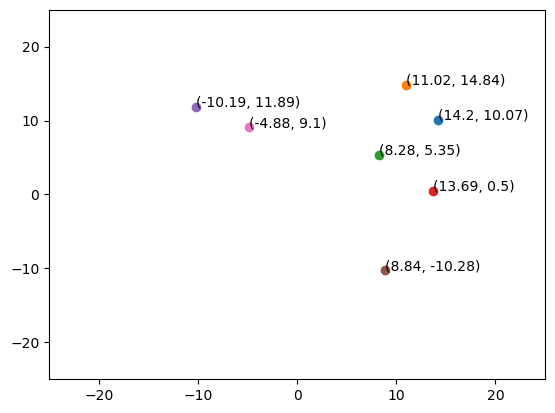

In [21]:
for i in P:
    plt.scatter(i[0],i[1])
    
for i in range(len(P)):
    plt.text(P[i][0], P[i][1], f"({P[i][0]}, {P[i][1]})")


plt.xlim(-25,25)
plt.ylim(-25,25)
plt.show()

In [22]:
start1 = time.time()

Children = {}
for p in P:
    Children[tuple(p)] = []
Ham_cycle_dict  = {}

n = len(P)
repeat_set = []
Branch_total = [[] for k in range(n+1)]
Children = {}
keys = ['e','center','radius', 'start_angle','end_angle','a','b','degree','constant']
order = {}

FSC_intersection = {}


Branch = {}
c = 0

FSCs = []
FSC_total = [[] for k in range(n+1)]
FSC_branch = {}

branch_num = 0    
FSC_num = 0

for p in P:
    Branch_total[1].append(branch_num)
    Children[branch_num] = []
    order[branch_num] = {branch_num}
    values = [p, p, 0, 0, 2*np.pi, None, None, None,set()]
    Branch[branch_num] = dict(zip(keys,values))
    branch_num += 1


# GeoSteiner phase
for k in range(2,n+1):
    s = time.time()
    s1 = time.time()
    # Classic GeoSteiner phase, double merge
    for l in range(1,(k//2)+1):
        for b1 in Branch_total[l]:
            for b2 in Branch_total[k-l]:
                if not order[b1].intersection(order[b2]):
                    if k < n:
                        values = find_branch_d3(b1, b2)
                        if type(values) != type(None):
                            Children[branch_num] = [b1, b2]
                            Branch[branch_num] = dict(zip(keys,values))
                            Branch_total[k].append(branch_num)
                            order[branch_num] = order[b1].union(order[b2])
                            branch_num += 1

                    #Construte FSC
                    if k >= 2:
                        if k > 2:
                            FSC = Construct_FSC(b1,b2)
                        if k == 2:
                            if b1 > b2:
                                FSC = [{(tuple(Branch[b1]['e']),tuple(Branch[b2]['e']))},[Branch[b1]['e'],Branch[b2]['e']]]
                            else:
                                FSC = None
                        if type(FSC) != type(None):
                            FSC_branch[FSC_num] = FSC
                            FSC_intersection[FSC_num] = order[b1].union(order[b2])
                            FSC_total[k].append(FSC_num)
                            FSC_num += 1
                            FSCs.append(FSC[0])
    e1 = time.time()
    print("total time at stage 1 in ",k,"floor",e1-s1)
    
    # Search for all current branch and megre with odd FSC
    s2 = time.time()
    for b3 in Branch_total[k]:
        for k2 in range(2, k+1):
            if k + k2 < n:
                 for f1 in FSC_total[k2]:
                    if not FSC_intersection[f1].intersection(order[b3]):
                        values = find_branch_d4(b3, FSC_branch[f1][1], FSC_branch[f1][0])
                        if type(values) != type(None):
                            order[branch_num] = order[b3].union(FSC_intersection[f1])
                            Children[branch_num] = [b3]
                            Branch[branch_num] = dict(zip(keys,values))
                            Branch_total[k2 + k].append(branch_num)
                            branch_num += 1
    
    e2 = time.time()
    print("total time at stage 2 in ",k,"floor",e2-s2)

    # Search for all current FSC and megre with odd branch
    s3 = time.time()
    for f2 in FSC_total[k]:
        for k1 in range(1, k):
            if k1 + k < n:
                for b4 in Branch_total[k1]:
                    if not FSC_intersection[f2].intersection(order[b4]):
                        values = find_branch_d4(b4, FSC_branch[f2][1], FSC_branch[f2][0])
                        if type(values) != type(None):
                            order[branch_num] = FSC_intersection[f2].union(order[b4])
                            Children[branch_num] = [b4]
                            Branch[branch_num] = dict(zip(keys,values))
                            Branch_total[k1 + k].append(branch_num)
                            branch_num += 1
    
    e3 = time.time()
    print("total time at stage 3 in ",k,"floor",e3-s3)
    
    
                                                    
    e = time.time()
    print("total time in ",k," floor",e-s)
end1 = time.time()

total time at stage 1 in  2 floor 0.0
total time at stage 2 in  2 floor 0.058951377868652344
total time at stage 3 in  2 floor 0.008260965347290039
total time in  2  floor 0.06721234321594238
total time at stage 1 in  3 floor 0.0315546989440918
total time at stage 2 in  3 floor 0.14956974983215332
total time at stage 3 in  3 floor 0.05706143379211426
total time in  3  floor 0.23818588256835938
Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-11
total time at stage 1 in  4 floor 0.21659350395202637
total time at stage 2 in  4 floor 0.28603100776672363
total time at stage 3 in  4 floor 0.0585627555847168
total time in  4  floor 0.5611872673034668
total time at stage 1 in  5 floor 0.5707211494445801
total time at stage 2 in  5 floor 0.0
total time at stage 3 in  5 floor 0.0
total time in  5  floor 0.5707211494445801
total time at stage 1 in  6 floor 1.5123791694641113
total time at stage 2 in  6 floor 0.0
total time at stage 3 in  6 floor 0.0
total t

In [23]:
# find the intersection for all FSC
FSCs_intersection = []
for fsc in FSCs:
    isector = SweepIntersector()
    Edge = [edge for edge in fsc]
    isectDic = isector.findIntersections(Edge)
    count_intersection = 0
    for seg,isects in isectDic.items():
        count_intersection = len(isects[1:-1])
        count = 0
        while count+1 < len(isects):
            Edge.append(((isects[count][0],isects[count][1])
                        ,(isects[count+1][0],isects[count+1][1])))
            count = count + 1
        if seg in Edge:
            Edge.remove(seg)
    FSCs_intersection.append(Edge)

In [24]:
P2 = [tuple(i) for i in P1]

In [25]:
E_count = {}
count = 0
C = {}

# reomve all edges and add double arcs
for fst in FSCs_intersection:
    for i in range(len(fst)):
        length = distance.euclidean(list(fst)[i][0], list(fst)[i][1])
        if length > 1e-6:
            E_count[count] = (tuple(list(fst)[i][0]),tuple(list(fst)[i][1]))
            C[count] = length
            count += 1
            E_count[count] = (tuple(list(fst)[i][1]),tuple(list(fst)[i][0]))
            C[count] = length
            count += 1
multi = {}
for i in range(len(C)):
    multi[E_count[i]] = C[i]
arc,cost = gp.multidict(multi)

In [26]:
G = nx.DiGraph()
G.add_edges_from(arc)
G_neighbor = {}
for node in G:
    G_neighbor[node] = list(G.neighbors(node))

In [27]:
combin = []
for a in A:
    for b in B:
        if a != b:
            combin.append((a,b))

In [28]:
start_ILP1 = time.time()


m = gp.Model('Steiner')

time_1 = time.time()
flow = m.addVars(combin,arc,vtype=GRB.BINARY, name = 'x')
time_1_end = time.time()
print('flow',len(flow),time_1_end-time_1)


time_1 = time.time()
cap= m.addVars(arc, vtype = GRB.BINARY,name = 'y')
time_1_end = time.time()
print(len(cap))
print('cap',time_1_end-time_1)

time_1 = time.time()
flow_constrain1 = m.addConstrs(gp.quicksum(flow[a,b,a,v] for v in G_neighbor[a]) - 
                               gp.quicksum(flow[a,b,v,a] for v in G_neighbor[a]) 
                               ==  1 for (a,b) in combin)
time_1_end = time.time()
print(len(flow_constrain1))
print('constrain1',time_1_end-time_1)

time_1 = time.time()
flow_constrain2 = m.addConstrs(gp.quicksum(flow[a,b,b,v] for v in G_neighbor[b]) - 
                               gp.quicksum(flow[a,b,v,b] for v in G_neighbor[b]) 
                               ==  -1 for (a,b) in combin)
time_1_end = time.time()
print(len(flow_constrain2))
print('constrain2',time_1_end-time_1)


time_1 = time.time()
flow_constrain3 = m.addConstrs(gp.quicksum(flow[a,b,v1,v2] for v1 in G_neighbor[v2] if v2 != a and v2 != b) == 
                               gp.quicksum(flow[a,b,v2,v3] for v3 in G_neighbor[v2] if v2 != a and v2 != b) 
                               for v2 in G for (a,b) in combin)
time_1_end = time.time()
print(len(flow_constrain3))
print('constrain3',time_1_end-time_1) 

time_1 = time.time()
flow_constrain4 = m.addConstrs(flow[a,b,i[0],i[1]] <= cap[i] for i in arc for (a,b) in combin)
time_1_end = time.time()
print(len(flow_constrain4))
print('constrain4',time_1_end-time_1)


m.setObjective(gp.quicksum(cost[i]*cap[i] for i in arc), GRB.MINIMIZE)
m.optimize()

m.write("model.lp")
for v in m.getVars():
    if v.x > 1e-6:
        print(v.varName, v.x)

print('Total value: ', m.objVal)
end_ILP1 = time.time()



flow 32240 1.2454006671905518
1240
cap 0.03194904327392578
26
constrain1 0.02721571922302246
26
constrain2 0.02239847183227539
7384
constrain3 0.5832967758178711
32240
constrain4 1.5682706832885742
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 39676 rows, 33480 columns and 128960 nonzeros
Model fingerprint: 0xbfa5d14d
Variable types: 0 continuous, 33480 integer (33480 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-02, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 455.9937393
Presolve removed 2054 rows and 1080 columns
Presolve time: 0.47s
Presolved: 37622 rows, 32400 columns, 124800 nonzeros
Variable types: 0 continuous, 32400 integer (32400 binary)
Deterministic concurrent L

In [29]:
print(end_ILP1-start_ILP1)
test = end_ILP1-start_ILP1

12.38944959640503


In [30]:
def plot_graph(vals):
    Edge_graph = []
    Vertex_graph = []

    for i in arc:
        if vals[i]> 1e-6:
            Edge_graph.append(((float(i[0][0]),float(i[0][1])),(float(i[1][0]),float(i[1][1]))))
    for i in Edge_graph:
        for j in i:
            if j not in Vertex_graph:
                Vertex_graph.append(j)
    Edge = []
    for i in range(len(Edge_graph)):
        for j in range(len(Vertex_graph)):
            if Edge_graph[i][0] == Vertex_graph[j]:
                p1 = j
            if Edge_graph[i][1] == Vertex_graph[j]:
                p2 = j
        Edge.append((p1,p2))
    fig, ax = plt.subplots()
    plt.title('AB Network')

    G = nx.DiGraph()
    G.add_edges_from(Edge)
    list_deg2 = []


    colour_map = []
    for i in G:
        if Vertex_graph[i] in A and Vertex_graph[i] not in B:
            colour_map.append('red')
        if Vertex_graph[i] in B and Vertex_graph[i] not in A:
            colour_map.append('blue')
        if Vertex_graph[i] in A and Vertex_graph[i] in B:
            colour_map.append('y')
        if Vertex_graph[i] not in A and Vertex_graph[i] not in B:
            colour_map.append('g')
    
    nx.draw(G, Vertex_graph, with_labels=True, node_color=colour_map)
    ax.set_axis_on()
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

    plt.xlim(-25,25)
    plt.ylim(-25,25)
    plt.show()
    

In [31]:
P2 = [(i,j) for (i,j) in P1]
print("A =",A,"\nB =",B,"\nP1 =",P2)

A = [(14.2, 10.07), (11.02, 14.84), (13.69, 0.5), (-10.19, 11.89), (8.84, -10.28), (-4.88, 9.1)] 
B = [(14.2, 10.07), (11.02, 14.84), (8.28, 5.35), (-10.19, 11.89), (8.84, -10.28)] 
P1 = [(14.2, 10.07), (11.02, 14.84), (8.28, 5.35), (13.69, 0.5), (-10.19, 11.89), (8.84, -10.28), (-4.88, 9.1)]


In [32]:
vals = m.getAttr('X', cap)

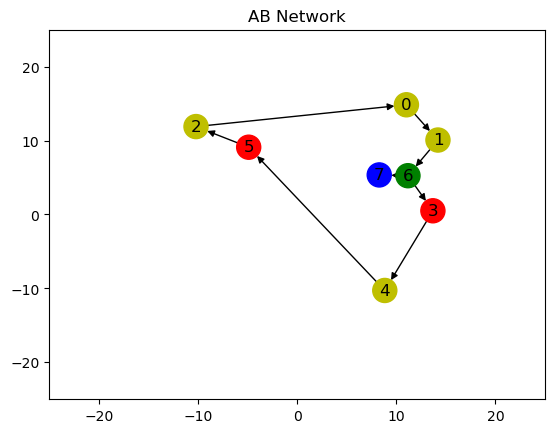

In [33]:
plot_graph(vals)

In [34]:
print('Total value: ', m.objVal)

Total value:  82.67313974101702


In [35]:
end = time.time()
print(end-start)

17.120922803878784


In [36]:
len(Branch)

5241

In [37]:
len(FSCs_intersection)

180

In [38]:
print(len(P2))

7
